In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import scipy as sp
import h5py
import sys
from icecube import astro
sys.path.append('/home/apizzuto/Nova/scripts/')
from Novae import Nova
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import *

import matplotlib as mpl
plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
mpl.rcParams['lines.linewidth'] = 2.

In [5]:
samples = ['GRECO', 'ORCA', 'Upgrade', 'OscNext']
effective_areas = {sam: {} for sam in samples}
#splines = {sam: {} for sam in samples}

# Start with GRECO

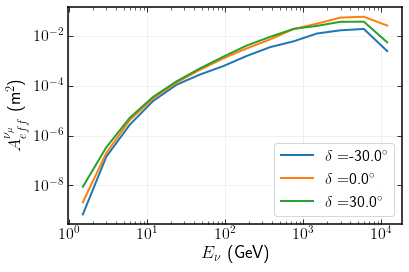

In [6]:
for ii, dec in enumerate([-30., 0., 30.,]):
    nov = Nova('hi', -2., 0.0, dec*np.pi/180., 57000., 1., 
               flux_norm=1e-7, cutoff = None)
    ens = mids(nov.aeff_dict['bins']); aeff = nov.aeff_dict['vals']
    msk = aeff > 0
    plt.plot(ens[msk], aeff[msk], label = r'$\delta = $' + str(dec) + r'$^\circ$')
    effective_areas['GRECO'][dec] = (ens[msk], aeff[msk])
    if dec == 0:
        greco_spl = sp.interpolate.UnivariateSpline(np.log10(ens[msk].copy()), np.log10(aeff[msk].copy()))
        greco_max_e = np.max(ens[msk].copy())
        greco_max_a = np.max(aeff[msk].copy())
                                                                  
def greco_aeff_spl(ens):
    return np.where(ens < greco_max_e, 10.**greco_spl(np.log10(ens)), greco_max_a)
    
plt.legend(loc='lower right')
plt.loglog()
plt.ylabel(r'$A^{\nu_{\mu}}_{eff}$ (m$^2$)')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.show()

# Next, do OscNext

In [7]:
osc_next = h5py.File('/data/ana/LE/oscNext/pass2/pisa/v01.01/oscNext_pisa_genie_0000_v01.01.hdf5')

In [8]:
delta_sin_dec = 0.1
delta_omega = 2.*np.pi*delta_sin_dec*2.

def get_sim(flav, channel, anti='', declination = 0.0):
    tmp = osc_next.get(flav + anti + '_' + channel)
    cols = ['I3MCWeightDict.OneWeight', 'I3MCWeightDict.NEvents', 'I3MCWeightDict.gen_ratio', 
           'L7_MuonClassifier_ProbNu', 'L7_CoincidentMuon_bool', 'MCInIcePrimary.energy',
           'MCInIcePrimary.dir.coszen']
    arrs = np.array([tmp[col].value for col in cols])
    msk = (tmp['L7_MuonClassifier_ProbNu'].value > 0.3) * (tmp['L7_CoincidentMuon_bool'].value == 1.0)
    sin_dec = np.sin(np.radians(declination))
    zen_msk = (tmp['MCInIcePrimary.dir.coszen'] > (sin_dec - delta_sin_dec)) * (tmp['MCInIcePrimary.dir.coszen'] < (sin_dec + delta_sin_dec))
    msk *= zen_msk
    arrs = arrs[:, msk]
    df = pd.DataFrame(arrs.T, columns=cols)
    df['OneWeight'] = df['I3MCWeightDict.OneWeight'] / (df['I3MCWeightDict.NEvents'] * df['I3MCWeightDict.gen_ratio'])
    return df

def osc_next_aeff(flav, channel, anti='', declination = 0.0):
    e_bins = np.logspace(0., 4., 31)
    mids = 10.**(np.log10(e_bins)[:-1] + (np.diff(np.log10(e_bins))[:] / 2.))
    df = get_sim(flav, channel, anti=anti, declination=declination)
    delta_log_e = np.mean(np.diff(np.log10(e_bins)))*np.log(10.)
    flav_nfiles = {'numu': 1495, 'nue': 624, 'nutau': 324}
    n_files = flav_nfiles[flav]
    h, b = np.histogram(df['MCInIcePrimary.energy'], bins = e_bins, weights = df['OneWeight'] / df['MCInIcePrimary.energy'] / delta_omega / delta_log_e / 1e4 / n_files)
    return mids, h

/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


[]

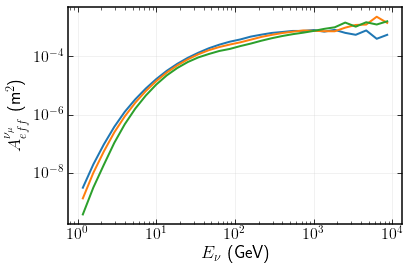

In [9]:
for declination in [-30., 0., 30]:
    ens, aeffs_nucc = osc_next_aeff('numu', 'cc', declination=declination)
    ens, aeffs_nunc = osc_next_aeff('numu', 'cc', declination=declination)
    aeffs_nu = aeffs_nucc + aeffs_nunc
    ens, aeffs_nubarcc = osc_next_aeff('numu', 'cc', anti='bar', declination=declination)
    ens, aeffs_nubarnc = osc_next_aeff('numu', 'nc', anti='bar', declination=declination)
    aeffs_nubar = aeffs_nubarcc + aeffs_nubarnc
    aeffs = (aeffs_nu + aeffs_nubar) / 2.
    effective_areas['OscNext'][declination] = (ens.copy(), aeffs)
    plt.plot(ens, aeffs)
    if declination == 0:
        oscnext_spl = sp.interpolate.UnivariateSpline(np.log10(ens.copy()), np.log10(aeffs.copy()))
        oscnext_max_e = np.max(ens.copy())
        oscnext_max_a = np.max(aeffs.copy())
        
def oscnext_aeff_spl(ens):
    return np.where(ens < oscnext_max_e, 10.**oscnext_spl(np.log10(ens)), oscnext_max_a)
        
plt.ylabel(r'$A^{\nu_{\mu}}_{eff}$ (m$^2$)')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.loglog()

# Now, the Upgrade

In [10]:
upgrade = pd.read_csv('/home/apizzuto/Nova/Upgrade_MC/events/neutrino_mc.csv')

In [11]:
delta_sin_dec = 0.1
delta_omega = 2.*np.pi*delta_sin_dec*2.

def get_upgrade_sim(flav, channel, anti='', declination = 0.0):
    flav_map = {'nue': 12, 'nuebar': -12, 'numu': 14, 'numubar': -14,
               'nutau': 16, 'nutaubar': -16}
    channel_map = {'nc': 0, 'cc': 1}
    flav_msk = upgrade['pdg'] == flav_map[flav+anti]
    cos_zen = np.cos(upgrade['true_zenith'])
    sin_dec = np.sin(np.radians(declination))
    zen_msk = (cos_zen > (sin_dec - delta_sin_dec)) * (cos_zen < (sin_dec + delta_sin_dec))
    channel_msk = upgrade['current_type'] == channel_map[channel]
    msk = flav_msk * zen_msk * channel_msk
    arrs = upgrade.values.T[:, msk]
    df = pd.DataFrame(arrs.T, columns=upgrade.columns)
    return df

def upgrade_aeff(flav, channel, anti='', declination = 0.0):
    e_bins = np.logspace(0., 3., 31)
    mids = 10.**(np.log10(e_bins)[:-1] + (np.diff(np.log10(e_bins))[:] / 2.))
    df = get_upgrade_sim(flav, channel, anti=anti, declination=declination)
    delta_log_e = np.mean(np.diff(np.log10(e_bins)))*np.log(10.)
    h, b = np.histogram(df['true_energy'], bins = e_bins, weights = df['weight'] / df['true_energy'] / delta_omega / delta_log_e)
    return mids, h

/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


[]

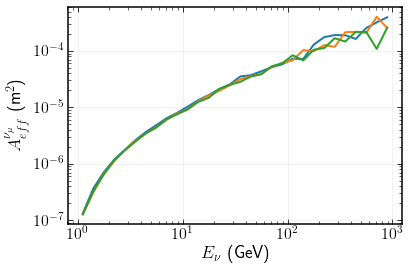

In [12]:
for declination in [-30., 0., 30]:
    ens, aeffs_nucc = upgrade_aeff('numu', 'cc', declination=declination)
    ens, aeffs_nunc = upgrade_aeff('numu', 'cc', declination=declination)
    aeffs_nu = aeffs_nucc + aeffs_nunc
    ens, aeffs_nubarcc = upgrade_aeff('numu', 'cc', anti='bar', declination=declination)
    ens, aeffs_nubarnc = upgrade_aeff('numu', 'nc', anti='bar', declination=declination)
    aeffs_nubar = aeffs_nubarcc + aeffs_nubarnc
    aeffs = (aeffs_nu + aeffs_nubar) / 2.
    effective_areas['Upgrade'][declination] = (ens.copy(), aeffs)
    plt.plot(ens, aeffs)
    if declination == 0:
        upgrade_spl = sp.interpolate.UnivariateSpline(np.log10(ens.copy()), np.log10(aeffs.copy()))
        upgrade_max_e = np.max(ens.copy())
        upgrade_max_a = np.max(aeffs.copy())
        
def upgrade_aeff_spl(ens):
    return np.where(ens < upgrade_max_e, 10.**upgrade_spl(np.log10(ens)), upgrade_max_a)
    
    
plt.ylabel(r'$A^{\nu_{\mu}}_{eff}$ (m$^2$)')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.loglog()

# Then, ORCA

In [13]:
orca = {}
for flav in ['numu', 'numubar', 'nue', 'nuebar']:
    orca[flav] = {}
    orca[flav]['A'] = pd.read_csv('/home/apizzuto/Nova/data/orca_115_{}.csv'.format(flav), header=0, names = ['Energy', 'Aeff'])
    orca[flav]['logspline'] = sp.interpolate.UnivariateSpline(np.log10(orca[flav]['A']['Energy']), 
                                                              np.log10(orca[flav]['A']['Aeff']))

[]

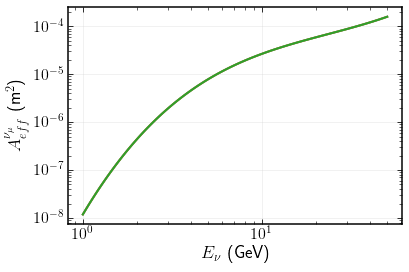

In [14]:
for declination in [-30., 0., 30]:
    logens = np.linspace(0., 1.7, 100)
    ens = np.power(10., logens)
    aeffs_nu = np.power(10., orca['numu']['logspline'](logens))
    aeffs_nubar = np.power(10., orca['numubar']['logspline'](logens))
    aeffs = (aeffs_nu + aeffs_nubar) / 2.
    effective_areas['ORCA'][declination] = (ens.copy(), aeffs)
    plt.plot(ens.copy(), aeffs)
    if declination == 0:
        orca_spl = sp.interpolate.UnivariateSpline(np.log10(ens.copy()), np.log10(aeffs.copy()))
        orca_max_e = np.max(ens.copy())
        orca_max_a = np.max(aeffs.copy())
        
def orca_aeff_spl(ens):
    return np.where(ens < orca_max_e, 10.**orca_spl(np.log10(ens)), orca_max_a)
    
    
plt.ylabel(r'$A^{\nu_{\mu}}_{eff}$ (m$^2$)')
plt.xlabel(r'$E_{\nu}$ (GeV)')
plt.loglog()

# Now put it all together

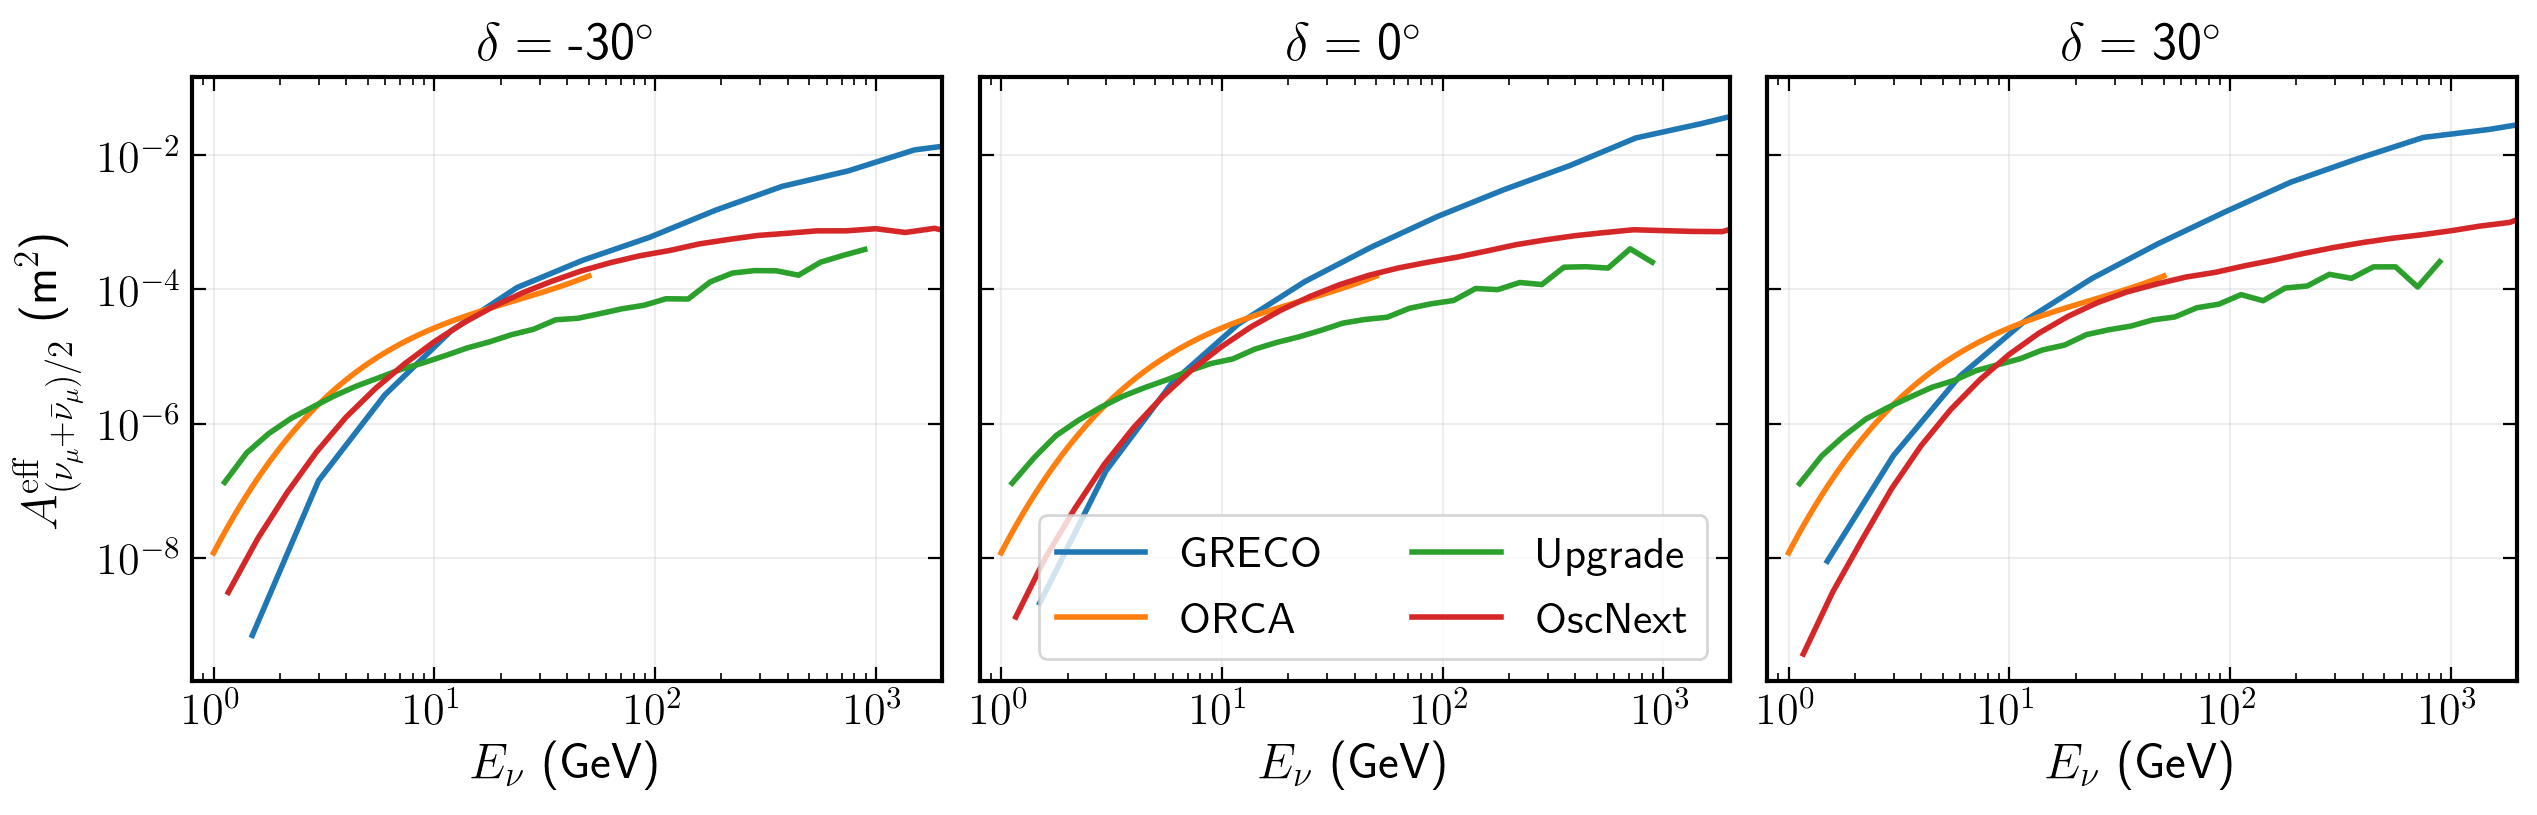

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharey=True, dpi=200)
plt.subplots_adjust(wspace=0.05)
fig.set_facecolor('w')

for ii, declination in enumerate([-30., 0., 30]):
    for sample in samples:
        sample_aeff = effective_areas[sample][declination]
        axs[ii].plot(sample_aeff[0], sample_aeff[1], label = sample)
    axs[ii].loglog()
    if ii == 0:
        axs[ii].set_ylabel(r'$A_{(\nu_{\mu}+\bar{\nu}_{\mu})/2}^{\mathrm{eff}}$ (m$^2$)')
    axs[ii].set_xlabel(r'$E_{\nu}$ (GeV)')
    if ii == 1:
        axs[ii].legend(loc = 'lower right', ncol=2)
    axs[ii].set_xlim(8e-1, 2e3)
    axs[ii].set_title(r'$\delta = \;$' + '{:.0f}'.format(declination) + r'$^{\circ}$')

All lines are average numu/numubar, and the sum of NC and CC. For the OscNext line I assumed there were 1000 files, so I just took the one that you pointed me to and scaled the normed oneweights by another factor of 1000. The Upgrade is the files from the data release, ORCA is from a 2019 ICRC proceedings, and GRECO is not the same as the one in the GRECO paper, but it’s the sample we’ve been using for transients (with some looser cuts to let in more higher energy stuff)

# Propagate some fluxes

In [16]:
def master_aeff(ens, sample):
    if sample == 'GRECO':
        return greco_aeff_spl(ens)
    elif sample == 'OscNext':
        return oscnext_aeff_spl(ens)
    elif sample == 'Upgrade':
        return upgrade_aeff_spl(ens)
    elif sample == 'ORCA':
        return orca_aeff_spl(ens)
    else:
        print("Unknown sample")
        return None
    
def dnde(ens, sample, spec_norm = 1., spec_ind=-2., ref_e = 1.):
    spec = spec_norm * np.power(ens / ref_e, spec_ind)
    return master_aeff(ens, sample) * spec

[]

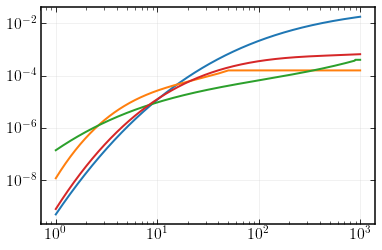

In [37]:
es = np.logspace(0., 3., 500)
for sam in samples:
    aes = master_aeff(es, sam)
    plt.plot(es, aes)
    
plt.loglog()

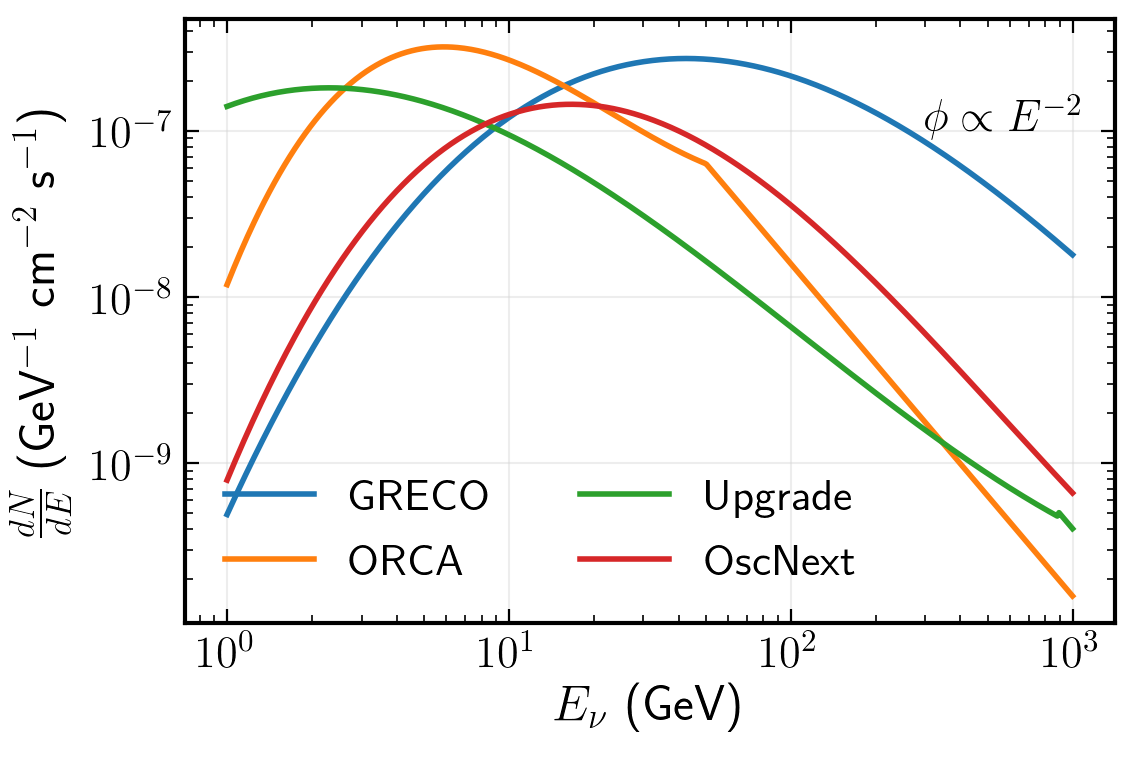

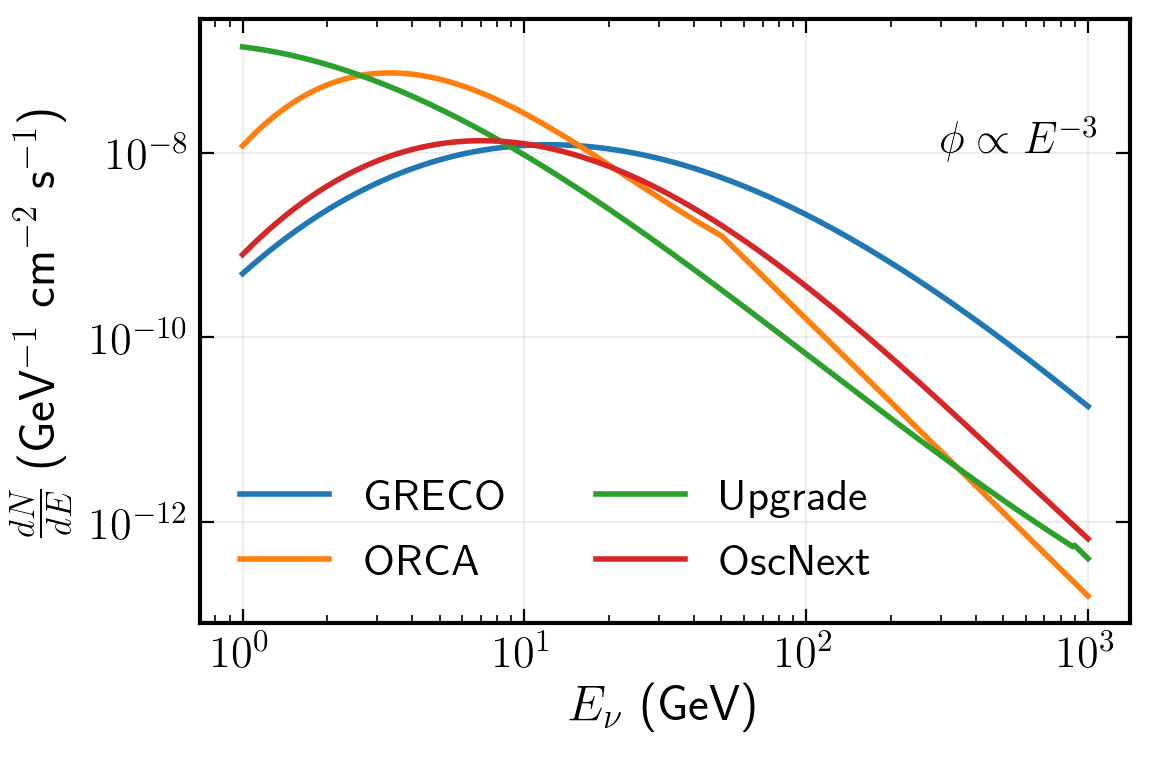

In [54]:
for spec_ind in [-2., -3.]:
    fig = plt.figure(dpi=200)
    for sam in samples:
        specs = dnde(es, sam, spec_ind=spec_ind)
        plt.plot(es, specs, label = sam) 
    plt.loglog()
    plt.ylabel(r'$\frac{dN}{dE}$ (GeV$^{-1}$ cm$^{-2}$ s$^{-1}$)')
    plt.xlabel(r'$E_{\nu}$ (GeV)')
    add_str = r'$\phi \propto E^{-2}$' if spec_ind == -2 else r'$\phi \propto E^{-3}$'
    yloc = 1e-7 if spec_ind == -2 else 1e-8
    plt.text(3e2, yloc, add_str)
    plt.legend(loc='lower left', ncol=2, frameon=False)
    plt.show()

In [44]:
def number_events(sample, spec_norm = 1., spec_ind=-2., ref_e = 1.):
    return sp.integrate.quad(dnde, 1., 100., 
                args=(sample, spec_norm, spec_ind, ref_e))[0]

In [46]:
greco_norm = number_events('GRECO', spec_ind=-3.)
for sam in samples:
    print sam, number_events(sam, spec_ind=-3.) / greco_norm

GRECO 1.0
ORCA 1.18258952144
Upgrade 0.736623357004
OscNext 0.566814043417
